## Credit Scoring Model for Financial Distress Prediction

Predicting 90+ days delinquency using the "Give Me Some Credit" dataset# Credit Risk Prediction Model

## Project Overview
This project predicts the likelihood of a borrower defaulting on credit (90+ days delinquency) using machine learning. The model is trained on the *"Give Me Some Credit"* dataset from Kaggle, containing 150,000+ anonymized financial records.

**Key Features**:
- Payment history (`NumberOfTime30-59DaysPastDueNotWorse`)
- Debt burden (`DebtRatio`, `MonthlyIncome`)
- Credit utilization (`RevolvingUtilizationOfUnsecuredLines`)
- Derived features (e.g., `WeightedDelinquency`, `HighUtilization` flag)

**Target Variable**:  
`SeriousDlqin2yrs` (1 = default within 2 years, 0 = no default)

# Import necessary libraries

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Data Reload 

In [2]:

import os

# Create Data directory if it doesn't exist
if not os.path.exists('Data'):
    os.makedirs('Data')

# Check if data files already exist
if not os.path.exists('Data/cs-training.csv'):
    try:
        # Try to download using Kaggle API
        !kaggle competitions download -c GiveMeSomeCredit -p Data
        !unzip Data/GiveMeSomeCredit.zip -d Data
        print("Dataset downloaded successfully using Kaggle API")
    except:
        print("Could not download using Kaggle API. Please download manually from https://www.kaggle.com/c/GiveMeSomeCredit/data")
        print("and place the files in the Data directory.")
else:
    print("Dataset files already exist in Data directory")

# Load the dataset
df = pd.read_csv('Data/cs-training.csv', index_col=0)

# Display basic information about the dataset
print("Dataset shape:", df.shape)
df.head()

Dataset files already exist in Data directory
Dataset shape: (150000, 11)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


# Data preprocessing

In [3]:
# Data preprocessing function
def preprocess_data(df):
    # Create a copy of the dataframe
    processed_df = df.copy()
    
    # Handle missing values
    # Impute MonthlyIncome with median by age groups
    age_groups = pd.cut(processed_df['age'], bins=[0, 30, 40, 50, 60, 100])
    for group in age_groups.unique():
        group_median = processed_df.loc[age_groups == group, 'MonthlyIncome'].median()
        processed_df.loc[(age_groups == group) & (processed_df['MonthlyIncome'].isnull()), 'MonthlyIncome'] = group_median
    
    # If there are still missing values, use overall median
    if processed_df['MonthlyIncome'].isnull().sum() > 0:
        overall_median = processed_df['MonthlyIncome'].median()
        processed_df['MonthlyIncome'].fillna(overall_median, inplace=True)
    
    # Replace null NumberOfDependents with 0
    processed_df['NumberOfDependents'].fillna(0, inplace=True)
    
    # Cap extreme values
    # Cap age between 21 and 100
    processed_df['age'] = np.clip(processed_df['age'], 21, 100)
    
    # Cap NumberOfTimes90DaysLate to 20
    processed_df['NumberOfTimes90DaysLate'] = np.clip(processed_df['NumberOfTimes90DaysLate'], 0, 20)
    
    # Feature engineering
    # Create WeightedDelinquency
    processed_df['WeightedDelinquency'] = (0.4 * processed_df['NumberOfTime30-59DaysPastDueNotWorse'] + 
                                          0.6 * processed_df['NumberOfTimes90DaysLate'])
    
    # Create IncomeToDependentsRatio
    processed_df['IncomeToDependentsRatio'] = processed_df['MonthlyIncome'] / (processed_df['NumberOfDependents'] + 1)
    
    # Create CreditLinesPerYear for those over 18
    processed_df['CreditLinesPerYear'] = 0
    mask = processed_df['age'] > 18
    processed_df.loc[mask, 'CreditLinesPerYear'] = processed_df.loc[mask, 'NumberOfOpenCreditLinesAndLoans'] / (processed_df.loc[mask, 'age'] - 18)
    
    # Create risk flags
    processed_df['HighUtilization'] = (processed_df['RevolvingUtilizationOfUnsecuredLines'] > 0.8).astype(int)
    processed_df['NoIncome'] = (processed_df['MonthlyIncome'] <= 0).astype(int)
    
    return processed_df

# Apply preprocessing
processed_df = preprocess_data(df)

# Display the processed dataframe
print("Processed dataframe shape:", processed_df.shape)
processed_df.head()

Processed dataframe shape: (150000, 16)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,WeightedDelinquency,IncomeToDependentsRatio,CreditLinesPerYear,HighUtilization,NoIncome
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,0.8,3040.0,0.481481,0,0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0.0,1300.0,0.181818,1,0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,1.0,3042.0,0.100000,0,0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0.0,3300.0,0.416667,0,0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,0.4,63588.0,0.225806,1,0


# Data Preparation

In [4]:
# Prepare data for modeling
def prepare_model_data(df):
    # Define features and target
    X = df.drop('SeriousDlqin2yrs', axis=1)
    y = df['SeriousDlqin2yrs']
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, scaler

# Prepare the data
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, scaler = prepare_model_data(processed_df)

# Function to train models with SMOTE during cross-validation
def train_model_with_smote_cv(model, X_train, y_train, param_grid=None, cv=5):
    # Define cross-validation strategy
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    # If param_grid is provided, perform grid search
    if param_grid:
        # Initialize GridSearchCV with ROC-AUC scoring
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring='roc_auc',
            cv=cv_strategy,
            n_jobs=-1,
            verbose=1
        )
        
        # Apply SMOTE and fit the model
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        grid_search.fit(X_resampled, y_resampled)
        
        # Get the best model
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        
        print(f"Best parameters: {best_params}")
        print(f"Best cross-validation ROC-AUC: {best_score:.4f}")
        
        return best_model
    else:
        # If no param_grid, just perform cross-validation with SMOTE
        cv_scores = []
        
        for train_idx, val_idx in cv_strategy.split(X_train, y_train):
            # Split data
            X_cv_train, X_cv_val = X_train[train_idx], X_train[val_idx]
            y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            # Apply SMOTE
            smote = SMOTE(random_state=42)
            X_resampled, y_resampled = smote.fit_resample(X_cv_train, y_cv_train)
            
            # Train model
            model.fit(X_resampled, y_resampled)
            
            # Predict and calculate ROC-AUC
            y_pred_proba = model.predict_proba(X_cv_val)[:, 1]
            cv_score = roc_auc_score(y_cv_val, y_pred_proba)
            cv_scores.append(cv_score)
        
        # Train final model on all training data with SMOTE
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        model.fit(X_resampled, y_resampled)
        
        print(f"Cross-validation ROC-AUC: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")
        
        return model

# Train Logistic Regression (baseline model)
print("Training Logistic Regression (Baseline Model)...")
log_reg_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
log_reg = LogisticRegression(random_state=42, max_iter=1000)
best_log_reg = train_model_with_smote_cv(log_reg, X_train_scaled, y_train, log_reg_params)

# Train Random Forest (primary model)
print("\nTraining Random Forest (Primary Model)...")
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf = RandomForestClassifier(random_state=42)
best_rf = train_model_with_smote_cv(rf, X_train_scaled, y_train, rf_params)

# Train XGBoost (comparison model)
print("\nTraining XGBoost (Comparison Model)...")
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
best_xgb = train_model_with_smote_cv(xgb_model, X_train_scaled, y_train, xgb_params)

# Save the models
import joblib
os.makedirs('models', exist_ok=True)
joblib.dump(best_log_reg, 'models/logistic_regression.pkl')
joblib.dump(best_rf, 'models/random_forest.pkl')
joblib.dump(best_xgb, 'models/xgboost.pkl')
joblib.dump(scaler, 'models/scaler.pkl')

Training Logistic Regression (Baseline Model)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation ROC-AUC: 0.8161

Training Random Forest (Primary Model)...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation ROC-AUC: 0.9899

Training XGBoost (Comparison Model)...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.9}
Best cross-validation ROC-AUC: 0.9854


['models/scaler.pkl']

# Reload models and scaler

In [ ]:

import joblib
best_log_reg = joblib.load('models/logistic_regression.pkl')
best_rf = joblib.load('models/random_forest.pkl')
best_xgb = joblib.load('models/xgboost.pkl')
scaler = joblib.load('models/scaler.pkl')

# Reload and preprocess raw data
df = pd.read_csv('Data/cs-training.csv', index_col=0)
processed_df = preprocess_data(df)  # Ensure preprocess_data() is defined

# Recreate splits and scaling
X = processed_df.drop('SeriousDlqin2yrs', axis=1)
y = processed_df['SeriousDlqin2yrs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  Model Evaluation

Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      0.83      0.90     27995
           1       0.22      0.68      0.34      2005

    accuracy                           0.82     30000
   macro avg       0.60      0.75      0.62     30000
weighted avg       0.92      0.82      0.86     30000

ROC-AUC: 0.8261


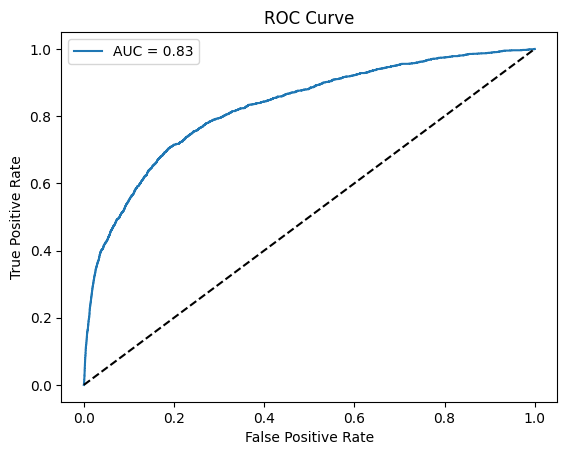


Random Forest:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     27995
           1       0.40      0.34      0.37      2005

    accuracy                           0.92     30000
   macro avg       0.68      0.65      0.66     30000
weighted avg       0.92      0.92      0.92     30000

ROC-AUC: 0.8337


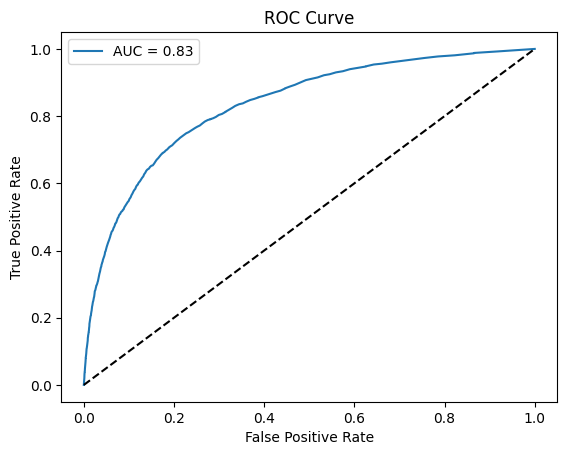


XGBoost:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     27995
           1       0.45      0.31      0.37      2005

    accuracy                           0.93     30000
   macro avg       0.70      0.64      0.67     30000
weighted avg       0.92      0.93      0.92     30000

ROC-AUC: 0.8398


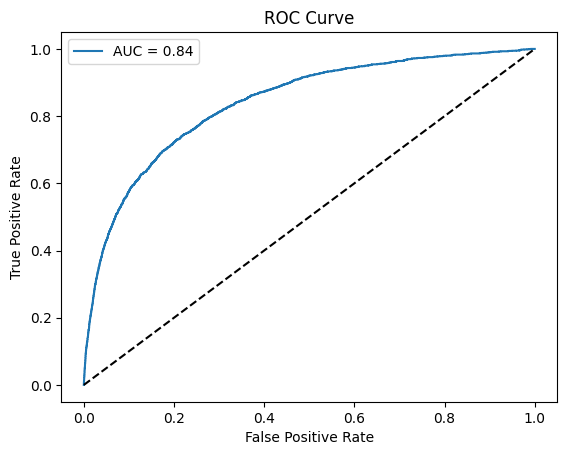

In [8]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Evaluate all models
print("Logistic Regression:")
evaluate_model(best_log_reg, X_test_scaled, y_test)

print("\nRandom Forest:")
evaluate_model(best_rf, X_test_scaled, y_test)

print("\nXGBoost:")
evaluate_model(best_xgb, X_test_scaled, y_test)

# Make Test Predictions

Single Example Prediction

In [9]:
# Select a random test example
sample_idx = np.random.randint(0, len(X_test))
sample_data = X_test_scaled[sample_idx].reshape(1, -1)  # Reshape for single prediction

# Get raw probability and binary prediction
risk_prob = best_rf.predict_proba(sample_data)[0, 1]  # P(default)
risk_class = best_rf.predict(sample_data)[0]          # 0=Good, 1=Bad

print(f"Predicted default probability: {risk_prob:.2%}")
print(f"Classification: {'High Risk' if risk_class == 1 else 'Low Risk'}")
print("\nActual values:")
print(f"- Target: {y_test.iloc[sample_idx]} (1=Default)")
print("- Features:")
print(X_test.iloc[sample_idx][['MonthlyIncome', 'DebtRatio', 'NumberOfTimes90DaysLate']])

Predicted default probability: 15.67%
Classification: Low Risk

Actual values:
- Target: 1 (1=Default)
- Features:
MonthlyIncome              8500.000000
DebtRatio                     0.031643
NumberOfTimes90DaysLate       0.000000
Name: 100482, dtype: float64


Batch Predictions (Top 5 Risky)

In [10]:
# Predict probabilities for all test data
y_proba = best_rf.predict_proba(X_test_scaled)[:, 1]

# Get top 5 highest-risk cases
high_risk_indices = np.argsort(y_proba)[-5:][::-1]
high_risk_df = X_test.iloc[high_risk_indices].copy()
high_risk_df['PredictedDefaultProbability'] = y_proba[high_risk_indices]
high_risk_df['ActualDefault'] = y_test.iloc[high_risk_indices].values

high_risk_df[['MonthlyIncome', 'DebtRatio', 'NumberOfTimes90DaysLate', 
              'PredictedDefaultProbability', 'ActualDefault']]

,MonthlyIncome,DebtRatio,NumberOfTimes90DaysLate,PredictedDefaultProbability,ActualDefault
72768,6041.0,21.0,20,1.0,1
117002,2779.5,15.0,20,1.0,1
140096,2779.5,22.0,20,1.0,1
100713,2779.5,0.0,20,1.0,1
112111,0.0,0.0,20,1.0,0


# Model Performance Metrics

Classification Report

In [11]:
from sklearn.metrics import classification_report

y_pred = best_rf.predict(X_test_scaled)
print(classification_report(y_test, y_pred, target_names=['Low Risk', 'High Risk']))

              precision    recall  f1-score   support

    Low Risk       0.95      0.96      0.96     27995
   High Risk       0.40      0.34      0.37      2005

    accuracy                           0.92     30000
   macro avg       0.68      0.65      0.66     30000
weighted avg       0.92      0.92      0.92     30000



Confusion Matrix

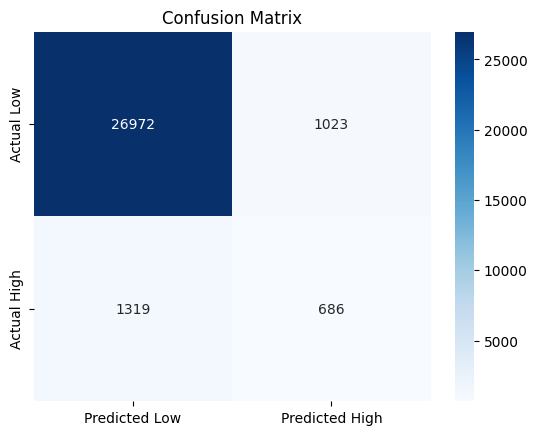

In [13]:
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Low', 'Predicted High'],
            yticklabels=['Actual Low', 'Actual High'])
plt.title('Confusion Matrix')
plt.show()

# Business Interpretation 


Risk Threshold Analysis

In [14]:
thresholds = [0.3, 0.5, 0.7]  # Example thresholds

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    print(f"\nThreshold: {thresh}")
    print(f"- High-Risk Customers: {sum(y_pred_thresh)}")
    print(f"- Default Capture Rate: {recall_score(y_test, y_pred_thresh):.2%}")


Threshold: 0.3
- High-Risk Customers: 4358
- Default Capture Rate: 58.30%

Threshold: 0.5
- High-Risk Customers: 1728
- Default Capture Rate: 34.51%

Threshold: 0.7
- High-Risk Customers: 607
- Default Capture Rate: 15.51%


Feature Impact

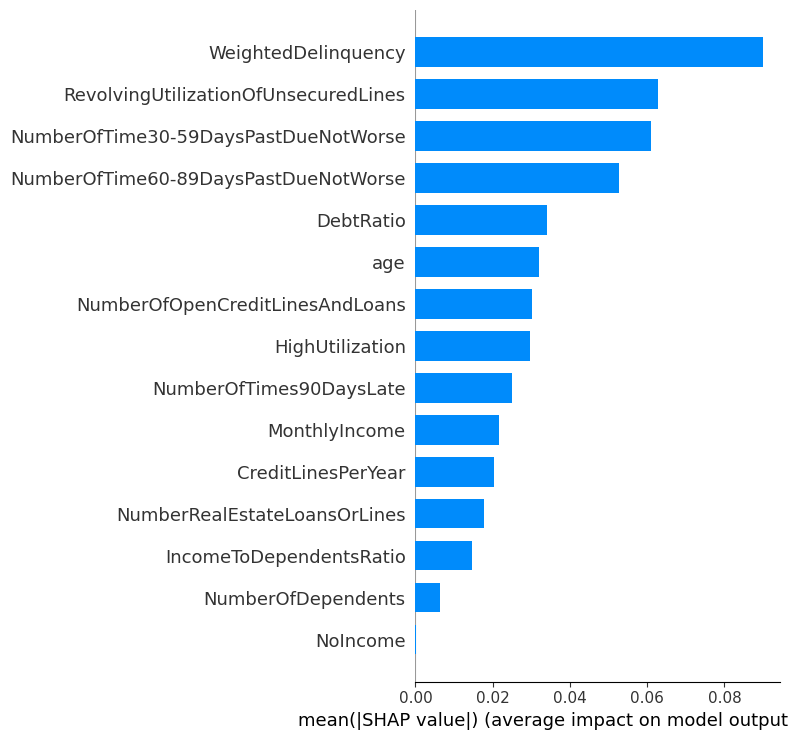

In [20]:
import shap

# 1. Initialize SHAP explainer
explainer = shap.TreeExplainer(best_rf)

# 2. Calculate SHAP values (use [1] for binary classification)
shap_values = explainer(X_test_scaled[:100])  # For 100 samples
# If using shap v0.44+, use:
# shap_values = explainer.shap_values(X_test_scaled[:100])[1]  # For class=1 (default)

# 3. Plot feature importance
shap.summary_plot(shap_values.values[:, :, 1],  # For class=1 (default risk)
                 X_test_scaled[:100], 
                 feature_names=X_test.columns, 
                 plot_type='bar')

# Save Predictions

In [21]:
output_df = X_test.copy()
output_df['DefaultProbability'] = y_proba
output_df['ActualDefault'] = y_test.values
output_df.to_csv('credit_risk_predictions.csv')